# Введение

> Как работает `tensorflow`?

In [2]:
from graphviz import Digraph

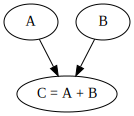

In [3]:
dot = Digraph(comment='Простой граф вычислений')
dot.node('A', 'A')
dot.node('B', 'B')
dot.node('C', 'C = A + B')
dot.edges(['AC', 'BC'])
display(dot)

Можно записать и более сложные выражения:

$D = E(A + B)$

Или, используя промежуточную вершину,   
$C = A + B$  
$D = EC$

1.   List item
2.   List item



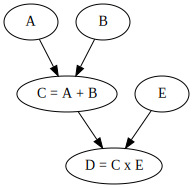

In [4]:
dot = Digraph(comment='Чуть более сложный граф вычислений')
dot.node('A', 'A')
dot.node('B', 'B')
dot.node('C', 'C = A + B')
dot.node('D', 'D = C x E')
dot.node('E', 'E')
dot.edges(['AC', 'BC', 'ED', 'CD'])
display(dot)

## Важные концепты

* Вершины графа - это _операции_ или плейсхолдеры (`placeholder`)
* Ребра графа - это переменные

Когда вы в tensorflow работаете с графом, вы сначала создаете плейсхолдеры, через которые данные попадают в граф, и переменные. После этого вы при помощи операций конструируете граф, соединяя переменные.


Для нас (не вдаваясь в детали реализации) разница между **переменными** и **плейсхолдерами** следующая: при обучении нейросети **переменные** - как правило, **параметры модели**, а **плейсхолдеры** - **входные и выходные данные**.







## Что дальше?

* Нужно добавить градиенты к известным операциям. 
* Нужно добавить оптимизатор, который сможет применять к существующему графу алгоритм обратного распространения ошибки. 
* Получается примерно такой результат (c сайта tensorflow):

![alt text](https://www.easy-tensorflow.com/files/1_1.gif)

## Как все это вычислять?

* Операции добавляются в _граф вычислений_
* Граф вычисляется в рамках сессиии. Например, сессия содержит в себе информаицю о том, на каком "железе" вы считаете.

## Минимальный пример на tensorflow 1.x

Ищем решение уравнения $Ax + b = y$

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

In [ ]:
learning_rate = 0.1

b = tf.Variable(shape=(), initial_value=0, dtype=tf.float32)
A = tf.Variable(shape=(), initial_value=0, dtype=tf.float32)

x = tf.placeholder(shape=(), dtype=tf.float32)
y = tf.placeholder(shape=(), dtype=tf.float32)

c = A * x + b

loss = tf.abs(y - c)

gradients = tf.gradients(loss, [A, b])

update_a = tf.assign_sub(A, gradients[0] * learning_rate)
update_b = tf.assign_sub(b, gradients[1] * learning_rate)

init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init)
  for it in range(10):
    a_val, b_val, _, _ = sess.run([A, b, update_a, update_b],
                                  feed_dict={x: 3, y: 2})
    print('Iter. %s' % str(it), a_val, b_val)

Iter. 0 0.3 0.1
Iter. 1 0.6 0.2
Iter. 2 0.6 0.2
Iter. 3 0.6 0.2
Iter. 4 0.6 0.2
Iter. 5 0.6 0.2
Iter. 6 0.6 0.2
Iter. 7 0.6 0.2
Iter. 8 0.6 0.2
Iter. 9 0.6 0.2


# Tensorflow 2.x

> Пример выше показывает, что tensorflow 1.x на низком уровне был не очень удобен.

* Решили избавиться от сессий и графов
* Добавили возможность делать `eager_execution` по умолчанию
* Граф все еще остался компилируемым, но теперь реализуется это по-другому

In [10]:
# Перезапустите runtime и затем загрузите версию 2.x!
# %tensorflow_version 2.x
# Load the TensorBoard notebook extension
%load_ext tensorboard
import os
import datetime
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
np.random.seed(42)

In [11]:
x = tf.Variable(2)
y = tf.Variable(3)

print(x * y)
print((x + y).numpy())

tf.Tensor(6, shape=(), dtype=int32)
5


## Gradient Tape

> Gradient Tape записывает операции, которые будут работать при автоматическом дифференцировании. 

In [20]:
trainable = tf.Variable(1, dtype=tf.float32)
non_trainable = tf.Variable(2, trainable=False, dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:  # persistent=False --> tape.gradient - только один раз
    x1 = trainable**2 * 2.
    x2 = non_trainable * 2

tape.gradient(x1, trainable)

<tf.Tensor: id=256, shape=(), dtype=float32, numpy=4.0>

In [21]:
tape.gradient(x1, trainable)

<tf.Tensor: id=265, shape=(), dtype=float32, numpy=4.0>

In [22]:
val = tape.gradient(x2, non_trainable)
val is None

True

## Оптимизаторы

Есть два варианта того, как можно использовать оптимизатор:
1. Через метод `Optimizer.minimize`
2. При помощи вычисления `GratiendTape.gradient` и `Optimizer.apply_gradients`

> Сначала создадим данные

In [23]:
x_0 = np.arange(0, 1, 0.01, dtype=np.float32)
x_1 = np.arange(0, 1, 0.01, dtype=np.float32)


def calculate_y(x_0, x_1):
  return 2 * x_0 + -3 * x_1 + np.random.normal(0, 0.2) +1

y = [calculate_y(*xs) for xs in product(x_0, x_1)]
X = np.array(list(product(x_0, x_1)), dtype=np.float32)

In [26]:
X.shape

(10000, 2)

In [27]:
len(y)

10000

Теперь сделаем простую модель, которую можно обучать методом градиентного спуска.

In [29]:
np.random.normal(0, 1, (2, 3))

array([[-0.59738106,  0.11041805,  1.19717853],
       [-0.77104216,  1.0008205 , -0.78167207]])

In [31]:
x_ = np.random.normal(0, 1, 2)
x_, x_.shape

(array([0.92193638, 0.85140994]), (2,))

In [32]:
W = tf.Variable(initial_value=np.random.normal(0, 1, 2), dtype=tf.float32)
b = tf.Variable(initial_value=0, dtype=tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
VARIABLES = [W, b]


def forward(X):
    return tf.tensordot(X, W, axes=1) + b


def mse_loss(y, y_hat):
    return tf.reduce_mean(tf.square(y_hat - y))


@tf.function
def train_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = forward(inputs)
    loss = mse_loss(targets, predictions)
  gradients = tape.gradient(loss, VARIABLES)  
  # MM: все, что считается в tape (даже после with, если это методы tape) - 
  # считается ВСЕ РАВНО внутри сессии with
  optimizer.apply_gradients(zip(gradients, VARIABLES))

_Примечание:_   
(МM): декоратор @tf.function делает внутренности функции статическим графом (если это возможно - то есть понятно, что граф меняться не будет), что оптимизирует и ускоряет вычисления. Без него тоже будет работать, но менее оптимально и быстро

> Обучим модель:

In [41]:
def fit(X, y, train_step, n_steps=1000):
    for i in range(n_steps):
        train_step(X, y)

In [47]:
fit(X, y, train_step, n_steps=1000)

In [48]:
print(W.numpy(), b.numpy())

[ 1.6768676 -2.4340456] 0.8722137


Получилось небольшое значение лосса:

In [49]:
loss = mse_loss(forward(X), y)
loss.numpy()

0.07529811

### Использование minimize


In [50]:
W = tf.Variable(initial_value=np.random.normal(0, 1, 2), dtype=tf.float32)
b = tf.Variable(initial_value=0, dtype=tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
VARIABLES = [W, b]


def forward(X):
  return tf.tensordot(X, W, axes=1) + b


def mse_loss_builder():
  """
  Здесь должен вычисляться лосс. При этом все операции с переменными, для 
  которых будут считаться градиенты, должны вычисляться _внутри_
  этой функции. Иначе градиенты для них будут неизвестны.
  """
  return tf.reduce_mean(tf.square(forward(X) - y))


for i in range(1_000):
  predictions = forward(X)
  optimizer.minimize(mse_loss_builder, var_list=VARIABLES)

In [51]:
W, b

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1.6232598, -1.9541684], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6489599>)

> Неправильный пример:

In [54]:
W = tf.Variable(initial_value=np.random.normal(0, 1, 2), dtype=tf.float32)
b = tf.Variable(initial_value=0, dtype=tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
VARIABLES = [W, b]


def forward(X):
  return tf.tensordot(X, W, axes=1) + b

y_hat = forward(X)

def mse_loss_builder():
  """
  Вычисляем y_hat вне этой функции.
  """
  return tf.reduce_mean(tf.square(y_hat - y))


try:
  for i in range(1_000):
    predictions = forward(X)
    optimizer.minimize(mse_loss_builder, var_list=VARIABLES)
except ValueError as e:
  print(e)

No gradients provided for any variable: ['Variable:0', 'Variable:0'].


> Можно передавать функцию, которая вычисляет лосс, завернув ее в анонимную функцию.

In [55]:
W = tf.Variable(initial_value=np.random.normal(0, 1, 2), dtype=tf.float32)
b = tf.Variable(initial_value=0, dtype=tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
VARIABLES = [W, b]


def forward(X):
  return tf.tensordot(X, W, axes=1) + b


def mse_loss_builder(X, y):
  return tf.reduce_mean(tf.square(forward(X) - y))


for i in range(1_000):
  predictions = forward(X)
  optimizer.minimize(lambda: mse_loss_builder(X, y), 
                      var_list=VARIABLES)


## API высокого уровня (keras)

Работать на низком уровне (не всегда) удобно. Точнее, могут возникнуть проблемы, если писать код неаккуратно или не следуя определенным соглашениям.

Для этого есть Keras API, который
1. Содержит в себе готовые слои, оптимизаторы, метрики, функции ошибок и прочее
2. Легко расширяется за счет новых классов, определенных пользователем

Что мы рассмотрим:
* Слои (`tf.keras.layers.Layer`)
* Коллбэки (`tf.keras.callbacks.Callback`)
* Модели (`tf.keras.Model`)

## Кастомный слой


In [60]:
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)  # [1]
    ...

  def build(self, input_shape):  # [2]
    ...
  
  def call(self, inputs):  # [3], #[4]
    ...

  def get_config(self):  # [5]
    base_config = super().get_config()  # [6] 
    ...

1. Инициализируем родительский класс
2. Этот метод собирает слой, в том числе инициализирует переменные внутри слоя
3. Метод `call` вызывается внутри метода `__call__` слоя и содержит действия для forward pass.
4. `inputs` - список входных тензоров для данного слоя.
5. Этот метод опциональный. Он нужен для того, чтобы слой был сериализуемым.
6. Важно не забыть получить параметры родительского класса.

## Linear Layer

Это слой, который выполняет линейное преобразование входных данных.

In [61]:
class Linear(tf.keras.layers.Layer):
  def __init__(self, units,  initializer='glorot_uniform', **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.initializer = keras.initializers.get(initializer)

  def build(self, input_shape):
    self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=self.initializer,
            name="kernel",
            trainable=True,
        )
  
  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

  def get_config(self):
    base_config = super().get_config()
    config = {
        'initializer': keras.initializers.serialize(self.initializer),
        'units': units
    }
    return dict(list(base_config.items()) + list(config.items()))


In [62]:
linear_layer = Linear(1)

In [63]:
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

In [64]:
linear_layer.trainable_variables

[]

In [65]:
history = model.fit(X, np.expand_dims(y, axis=-1), batch_size=512, epochs=100)

Train on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 2s 176us/sample - loss: 1.0983
Epoch 2/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.8968
Epoch 3/100
10000/10000 [==============================] - 0s 3us/sample - loss: 0.7614
Epoch 4/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.6675
Epoch 5/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.6009
Epoch 6/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.5514
Epoch 7/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.5137
Epoch 8/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.4837
Epoch 9/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.4589
Epoch 10/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.4377
Epoch 11/100
10000/10000 [==============================] - 0s 2us/sample - loss: 0.4192
Epoch

In [66]:
linear_layer.trainable_variables

[<tf.Variable 'sequential/linear/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 2.7995386],
        [-2.074382 ]], dtype=float32)>]

> Можете еще изучить [пример из документации](https://keras.io/examples/keras_recipes/antirectifier/)


## Callback

> Callback - самый простой способ добавить дополнительную логику в цикл обучения.

* Некоторые коллбеки включены по умолчанию: например, `History`.
* Можно сохранять модель: `ModelCheckpoint`
* Управлять процессом обучения: `EarlyStopping`, `LearningRateScheduler`, `ReduceLROnPlateau`.
* Следить за обучением: `TensorBoard`, `RemoteMonitor`.
* Создавать свою логику при помощи `LambdaCallback` или наследуясь от `Callback`.

In [76]:
linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-3)
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

In [77]:
history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping],
                    verbose=0)

In [78]:
len(history.history['loss'])

67

In [81]:
history.history['loss'][:5], len(history.history['loss'])

([1.491409877204895,
  1.3655536420822143,
  1.2629895742416382,
  1.176760124015808,
  1.1023998905181884],
 67)

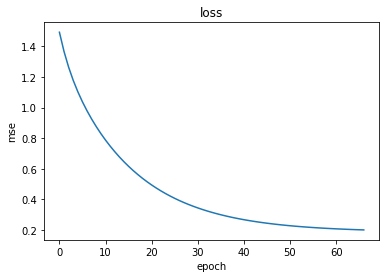

In [83]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('mse')
plt.xlabel('epoch');

### TensorBoard

In [84]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-4)
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

In [89]:
history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=0)

Text(0.5, 0, 'epoch')

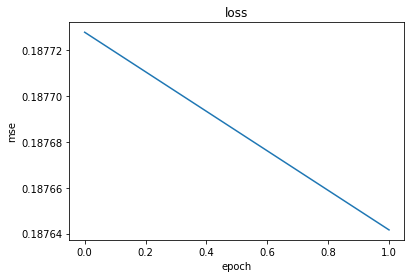

In [90]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('mse')
plt.xlabel('epoch')

In [95]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17504), started 0:09:25 ago. (Use '!kill 17504' to kill it.)

### Свой Callback

In [96]:
class PrintParameter(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('Variables after epoch {}: {}'.format(
        epoch, str([var.numpy() for var in self.model.trainable_variables])))

In [97]:
print_parameter = PrintParameter()

linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-4)
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

In [98]:
history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, print_parameter],
                    verbose=0)

Variables after epoch 0: [array([[-0.00810497],
       [-0.8909773 ]], dtype=float32)]
Variables after epoch 1: [array([[ 0.22615542],
       [-0.79141074]], dtype=float32)]
Variables after epoch 2: [array([[ 0.42382056],
       [-0.7237949 ]], dtype=float32)]
Variables after epoch 3: [array([[ 0.5919594 ],
       [-0.68150324]], dtype=float32)]
Variables after epoch 4: [array([[ 0.737151  ],
       [-0.65844464]], dtype=float32)]
Variables after epoch 5: [array([[ 0.8620687],
       [-0.6511252]], dtype=float32)]
Variables after epoch 6: [array([[ 0.97213495],
       [-0.6552753 ]], dtype=float32)]
Variables after epoch 7: [array([[ 1.0691894],
       [-0.668291 ]], dtype=float32)]
Variables after epoch 8: [array([[ 1.1556393 ],
       [-0.68839455]], dtype=float32)]
Variables after epoch 9: [array([[ 1.2337785],
       [-0.7134668]], dtype=float32)]
Variables after epoch 10: [array([[ 1.3047357],
       [-0.7421614]], dtype=float32)]
Variables after epoch 11: [array([[ 1.3701794],
  

### LambdaCallback
> Некоторые простые коллбэки можно создать при помощи `LambdaCallback`


In [ ]:
linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-4)


model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

# Важно: внутри lambda-функции используется определенная выше модель, 
# а не модель, доступная через self.model
print_parameter = keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print('Variables after epoch {}: {}'.format(
        epoch, str([var.numpy() for var in model.trainable_variables]))))

history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=10,
                    callbacks=[early_stopping, print_parameter],
                    verbose=0)

## Изменение training step'a для модели.

> Иногда кастомизации, которую дают коллбэки, может быть недостаточно. Например, если вы хотите включить в вашу модель сложную логику шага обучения.

Попробуем сделать модлеь, которая учитывает производные второго порядка при оптимизации.

> Кстати, `Model` наследует слою `Layer`. Поэтому модели keras API являются слоями, и их можно встраивать внутрь других моделей. Конечно, тогда нужно быть осторожнее с имзенениями `train_step`.

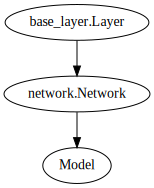

In [99]:
dot = Digraph(comment='Иерархия классов')
dot.node('L', 'base_layer.Layer')
dot.node('N', 'network.Network')
dot.node('M', 'Model')
dot.edges(['LN', 'NM'])
display(dot)

### Использование производных второго порядка

In [100]:
class NewtonModel(keras.Model):
  def train_step(self, data):
    inputs, targets = data
    trainable_vars = self.trainable_variables
    with tf.GradientTape() as tape2:  # [1]
      with tf.GradientTape() as tape1:  # [2]
        predictions = self(inputs)                       # MM: вызывается __call__, в котором зашит forward
        loss = self.compiled_loss(targets, predictions)
      gradients = tape1.gradient(loss, trainable_vars)  # [3]
    second_order = tape2.gradient(gradients, trainable_vars)  # [4] 

    updates = [g / so for so, g in zip(second_order, gradients)]  # [5]

    self.optimizer.apply_gradients(zip(updates, trainable_vars))  # [6]

    self.compiled_metrics.update_state(targets, predictions)  # [7]
    return {m.name: m.result() for m in self.metrics}

1. Создаем `GradientTape` для расчета производных 2го порядка. Он _снаружи_, потому что в его контексте _должны быть вычислены_ происводные 1го порядка.
2. Создаем `GradientTape` для расчета градиента.
3. Считаем градиенты.
4. Считаем прозводные второго порядка.
5. Считаем updates по формуле (упрощенной, т.к. только диагональные элементы из гессиана используются) $x^{(i+1)} = x^{(i)} - f''(x)^{-1} \cdot f'(x)$. Можете посмотреть [здесь](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization#Higher_dimensions) подробнее.
6. Применяем полученные градиенты. (ММ: только не градиенты, а апдейты)
7. Считаем метрики (нам бы хотелось видеть loss)

### Создаем и обучаем модель

In [102]:
inp = keras.Input(shape=(2,))
linear_layer = keras.layers.Dense(1)
predictions = linear_layer(inp)

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-4)
logdir = os.path.join("logs", "second_order",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model = NewtonModel(inp, predictions)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1), 
              loss='mse')

In [103]:
history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=0)

In [137]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17504), started 2:44:42 ago. (Use '!kill 17504' to kill it.)

### Сравним с обычной моделью

In [112]:
inp = keras.Input(shape=(2,))
linear_layer = keras.layers.Dense(1)
predictions = linear_layer(inp)

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                               min_delta=1e-4)
logdir = os.path.join("logs", "first_odrer", 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model = keras.Model(inp, predictions)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1), 
              loss='mse')

In [113]:
history = model.fit(X, np.expand_dims(y, axis=-1), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=0)

In [114]:
len(history.history['loss'])

2

Text(0.5, 0, 'epoch')

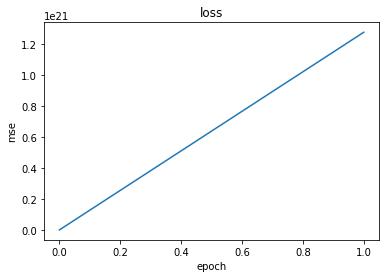

In [115]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('mse')
plt.xlabel('epoch')

# Нейронная сеть

In [117]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [118]:
x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255.
x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255.

In [122]:
model = keras.Sequential([
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=2,
                                               min_delta=1e-4,
                                               restore_best_weights=True)
logdir = os.path.join("logs", "mnist", 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test), 
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 24us/sample - loss: 1.1464 - accuracy: 0.7038 - val_loss: 0.5170 - val_accuracy: 0.8682
Epoch 2/100
60000/60000 [==============================] - 1s 23us/sample - loss: 0.4406 - accuracy: 0.8812 - val_loss: 0.3645 - val_accuracy: 0.8955
Epoch 3/100
60000/60000 [==============================] - 1s 25us/sample - loss: 0.3512 - accuracy: 0.9013 - val_loss: 0.3121 - val_accuracy: 0.9130
Epoch 4/100
60000/60000 [==============================] - 1s 15us/sample - loss: 0.3117 - accuracy: 0.9110 - val_loss: 0.2964 - val_accuracy: 0.9173
Epoch 5/100
60000/60000 [==============================] - 1s 15us/sample - loss: 0.2863 - accuracy: 0.9185 - val_loss: 0.2714 - val_accuracy: 0.9212
Epoch 6/100
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2666 - accuracy: 0.9234 - val_loss: 0.2518 - val_accuracy: 0.9280
Epoch 7/100
60000/60000 [=========================

In [134]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17504), started 2:09:12 ago. (Use '!kill 17504' to kill it.)

# Как это все (приблизительно) было устроено в tensorflow 1.x


## Базовые операции

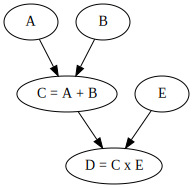

In [129]:
from graphviz import Digraph
import numpy as np

dot = Digraph(comment='Чуть более сложный граф вычислений')
dot.node('A', 'A')
dot.node('B', 'B')
dot.node('C', 'C = A + B')
dot.node('D', 'D = C x E')
dot.node('E', 'E')
dot.edges(['AC', 'BC', 'ED', 'CD'])
display(dot)

## Вспоминаем важные концепты
Пример по [deepideas.net](https://www.deepideas.net/deep-learning-from-scratch-i-computational-graphs/)

* Вершины графа - это _операции_ или плейсхолдеры (`placeholder`)
* Ребра графа - это переменные

Когда вы в tensorflow работаете с графом, вы сначала создаете плейсхолдеры, через которые данные попадают в граф, и переменные. После этого вы при помощи операций конструируете граф, соединяя переменные.

Репозиторий: [ссылка](https://github.com/danielsabinasz/TensorSlow).

`Variable`: минимально должна содержать список consumers, т.е. связанных переменных, и начальное значение.

`placeholder`: тоже должен содержать список связанных с ним переменных. Через него в граф поступают значения, которых не хватает для вычисления. Например, в нашем графе $A$, $B$ могут быть плейсхолдерами, а $E$ - переменной с некоторым начальным значением. 

Для нас разница между переменными и плейсхолдерами следующая: при обучении нейросети переменные - как правило, параметры модели, а плейсхолдеры - входные и выходные данные.







In [125]:
class Graph:
    def __init__(self):
        self.operations = []
        self.placeholders = []
        self.variables = []

    def as_default(self):
        global _default_graph
        _default_graph = self


class Operation:
    def __init__(self, input_nodes=[]):
        self.input_nodes = input_nodes
        self.consumers = []
        for input_node in input_nodes:
            input_node.consumers.append(self)
        _default_graph.operations.append(self)

    def compute(self):
        pass


class placeholder:
    def __init__(self):
        self.consumers = []
        _default_graph.placeholders.append(self)


class Variable:
    def __init__(self, initial_value=None):
        self.value = initial_value
        self.consumers = []
        _default_graph.variables.append(self)

## Можно создавать дополнительные операции

In [126]:
class add(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        return x_value + y_value


class matmul(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])

    def compute(self, a_value, b_value):
        return a_value.dot(b_value)

## Дальше остается создать сессию, в которой будут вычисляться результаты графа

In [127]:
import numpy as np


class Session:
    def run(self, operation, feed_dict={}):
        """Computes the output of an operation

        Args:
          operation: The operation whose output we'd like to compute.
          feed_dict: A dictionary that maps placeholders to values for this session
        """
        nodes_postorder = traverse_postorder(operation)

        for node in nodes_postorder:
            if type(node) == placeholder:
                node.output = feed_dict[node]
            elif type(node) == Variable:
                node.output = node.value
            else:  # Operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)
            if type(node.output) == list:
                node.output = np.array(node.output)
        return operation.output


def traverse_postorder(operation):
    nodes_postorder = []

    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

## И это работает!

In [128]:
Graph().as_default()

A = Variable([[1, 0], [0, -1]])
b = Variable([1, 1])

x = placeholder()

y = matmul(A, x)
z = add(y, b)

session = Session()
output = session.run(z, {x: [1, 2]})
print(output)

[ 2 -1]
